C:\Users\nmellachervu\AppData\Local\Temp\ipykernel_30300\1546481300.py:42: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  obligation_progression["Month"] = pd.to_datetime(obligation_progression["Month"], infer_datetime_format=True)
C:\Users\nmellachervu\AppData\Local\Temp\ipykernel_30300\1546481300.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obligation_progression["Month"] = pd.to_datetime(obligation_progression["Month"], infer_datetime_format=True)
C:\Users\nmellachervu\AppData\Local\Temp\ipykernel_30300\1546481300.py:43: 

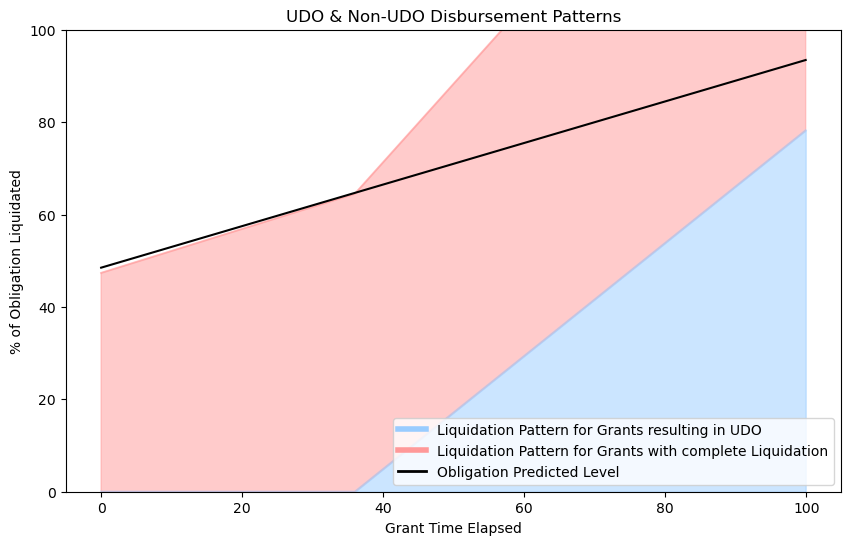

In [21]:
from flask import Flask, request, render_template
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import io
import base64

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
#from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Country_Name = "SOUTH AFRICA"

udo_ts = pd.read_excel("GHC FY21-23 Grant UDO Data.xlsx")
udo_c = pd.read_excel("GHC Grant Data Test.xlsx", skiprows=3, header=1)

# Select relevant columns
udo_c_selected = udo_c[["Unique ID","Country","CAN", "Grantee", "Fund Year", "Fund Description",  "UDO Status", "Recoverable", "Grant Start Date", "Grant End Date"]]

#udo_c_selected = udo_c_selected[udo_c_selected['Grant End Date'] < "2023-09-30"]
# Merge dataframes 
udo_combined = udo_ts.merge(udo_c_selected, how='left', on='Unique ID')
udo_combined.sort_values(by=['Unique ID', 'Month'], axis=0, inplace=True, ignore_index=True)

# Process data
obligation_progression = udo_combined[["Unique ID", "Country","CAN", "Grantee", "Fund Year", "Fund Description", "Month", "Obligation", "Disbursement", "Undisbursed Amount", "Grant Start Date", "Grant End Date", "UDO Status", "Recoverable"]]

obligation_progression["Month"] = pd.to_datetime(obligation_progression["Month"], infer_datetime_format=True)
obligation_progression["Grant End Date"] = pd.to_datetime(obligation_progression["Grant End Date"], infer_datetime_format=True)
obligation_progression["Grant End Date EOM"] = obligation_progression["Grant End Date"] + pd.offsets.MonthEnd(0)
obligation_progression["Grant Start Date EOM"] = obligation_progression["Grant Start Date"] + pd.offsets.MonthEnd(0)
obligation_progression = obligation_progression[obligation_progression["Month"] <= obligation_progression["Grant End Date EOM"]]
        
def month_diff(start, end):
    return (end.year - start.year) * 12 + end.month - start.month
        
        # Calculate grant length in number of months
obligation_progression["Grant Length Months"] = obligation_progression.groupby("Unique ID").apply(
    lambda group: group.apply(
         lambda row: month_diff(row["Grant Start Date EOM"], row["Grant End Date EOM"]), axis=1)).reset_index(level=0, drop=True)

# Calculate months elapsed since grant start date
obligation_progression["Grant Months Elapsed"] = obligation_progression.groupby("Unique ID").apply(
    lambda group: group.apply(
        lambda row: month_diff(row["Grant Start Date EOM"], row["Month"]), axis=1)).reset_index(level=0, drop=True)

# Calculate months elapsed since grant start date
obligation_progression["Grant Months Left"] = obligation_progression["Grant Length Months"] - obligation_progression["Grant Months Elapsed"]

# Calculate percent of grant time elapsed
obligation_progression["Grant Time Elapsed"] = obligation_progression["Grant Months Elapsed"] / obligation_progression["Grant Length Months"]

# Calculate percent of obligation spent
obligation_progression["Obligation Spent"] = obligation_progression["Disbursement"] / obligation_progression["Obligation"]

# Filter out rows with Obligation Spent greater than 1
obligation_progression = obligation_progression[obligation_progression["Obligation Spent"] <= 1]

# Filter out rows with Grant Time Elapsed less than 0
obligation_progression = obligation_progression[obligation_progression["Grant Time Elapsed"] >= 0]

# Convert to percentages
obligation_progression["Grant Time Elapsed"] *= 100
obligation_progression["Obligation Spent"] *= 100

# Ensure Obligation Spent is between 0 and 100
obligation_progression = obligation_progression[(obligation_progression["Obligation Spent"] >= 0) & (obligation_progression["Obligation Spent"] <= 100)]

uid_counts = obligation_progression['Unique ID'].value_counts()

# Step 2: Filter UIDs with more than 2 records
uids_with_more_than_2_records = uid_counts[uid_counts > 1].index

# Step 3: Filter the DataFrame to include only these UIDs
filtered_obligation_progression = obligation_progression[obligation_progression['Unique ID'].isin(uids_with_more_than_2_records)]

filtered_obligation_progression1 = filtered_obligation_progression[filtered_obligation_progression['Country'] == Country_Name]

obligation_progression = filtered_obligation_progression1

# Train model for UDO
X = obligation_progression[["Grant Time Elapsed"]]
y = obligation_progression["Obligation Spent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model_udo.predict(X_test)

udo_progression = obligation_progression[obligation_progression["UDO Status"] == "ULO"]
non_udo_progression = obligation_progression[obligation_progression["UDO Status"] == "Non ULO"]

# Train model for UDO
X = udo_progression[["Grant Time Elapsed"]]
y = udo_progression["Obligation Spent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_udo = LinearRegression()
model_udo.fit(X_train, y_train)
y_pred = model_udo.predict(X_test)

# Train model for Non-UDO
non_udo_progression_clean = non_udo_progression.replace([np.inf, -np.inf], np.nan).dropna()
X = non_udo_progression_clean[["Grant Time Elapsed"]]
y = non_udo_progression_clean["Obligation Spent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_nonudo = LinearRegression()
model_nonudo.fit(X_train, y_train)
y_pred = model_nonudo.predict(X_test)

# Generate predictions
continuous_range = np.arange(0.00, 100.0, 0.1)  # Adjusted range for percentages
disbursement_predictions = pd.DataFrame({'Grant Time Elapsed': continuous_range})

udo_pred = model_udo.predict(disbursement_predictions[['Grant Time Elapsed']])
non_udo_pred = model_nonudo.predict(disbursement_predictions[['Grant Time Elapsed']])
obl_pred = model.predict(disbursement_predictions[['Grant Time Elapsed']])

# Clip predictions to ensure they are between 0 and 100
udo_pred = np.clip(udo_pred, 0, 100)
non_udo_pred = np.clip(non_udo_pred, 0, 100)
obl_pred = np.clip(obl_pred, 0, 100)

disbursement_predictions['UDO Predicted Level'] = udo_pred
disbursement_predictions['Non UDO Predicted Level'] = non_udo_pred
disbursement_predictions['Obligation Predicted Level'] = obl_pred

# Plot the area for UDO and Non-UDO predictions
ax = disbursement_predictions.plot(
    kind='area',
    x='Grant Time Elapsed',
    y=['UDO Predicted Level', 'Non UDO Predicted Level'],
    figsize=(10, 6),
    alpha=0.5,
    title='UDO & Non-UDO Disbursement Patterns',
    xlabel='X-Axis: % of Grant Time Elapsed',
    ylabel='% of Obligation Liquidated',
    grid=True,
    legend=False,  # Disable automatic legend
    stacked=True,
    color=['#99CCFF', '#FF9999']  # Swap colors for UDO and Non-UDO areas
)

# Plot the line for Obligation Predicted Level
disbursement_predictions.plot(
    kind='line',
    x='Grant Time Elapsed',
    y='Obligation Predicted Level',
    color='black',
    ax=ax
)

ax.set_ylim(0, 100)

# Manually create the legend
custom_lines = [
    plt.Line2D([0], [0], color='#99CCFF', lw=4),
    plt.Line2D([0], [0], color='#FF9999', lw=4),
    plt.Line2D([0], [0], color='black', lw=2)
]
ax.legend(custom_lines, ['Liquidation Pattern for Grants resulting in UDO', 'Liquidation Pattern for Grants with complete Liquidation', 'Obligation Predicted Level'])

plt.show()